In [1]:
from build_dataset import MRIDatasetBuilder, MRIDataset, LatentImageProcessor
from torch.utils.data import DataLoader

# Build the dataset

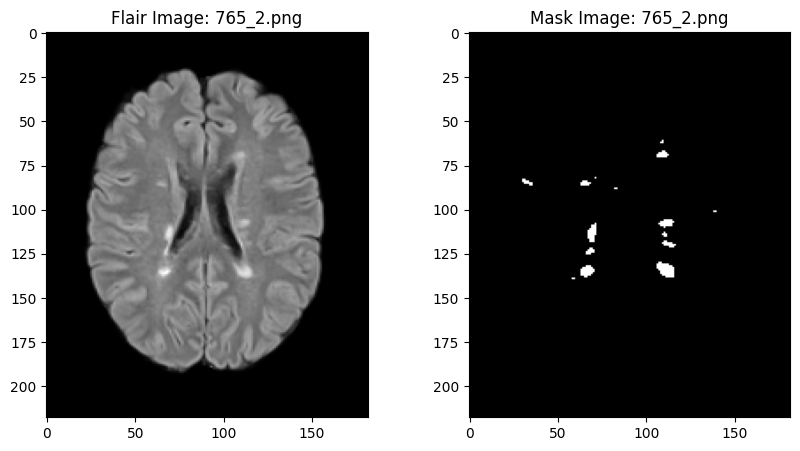

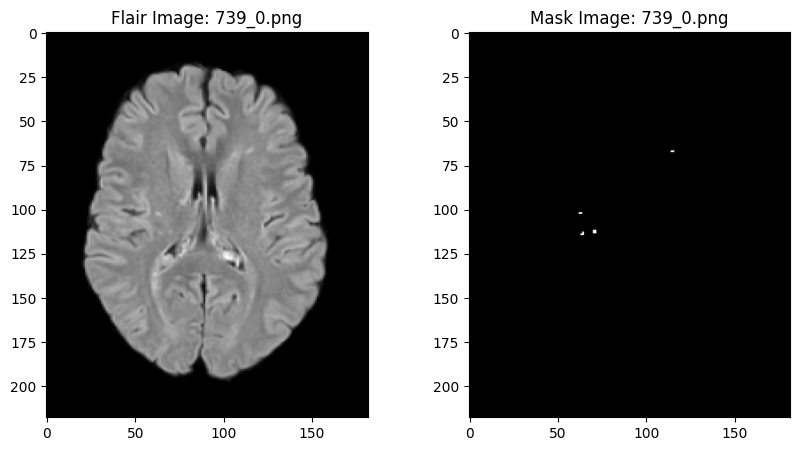

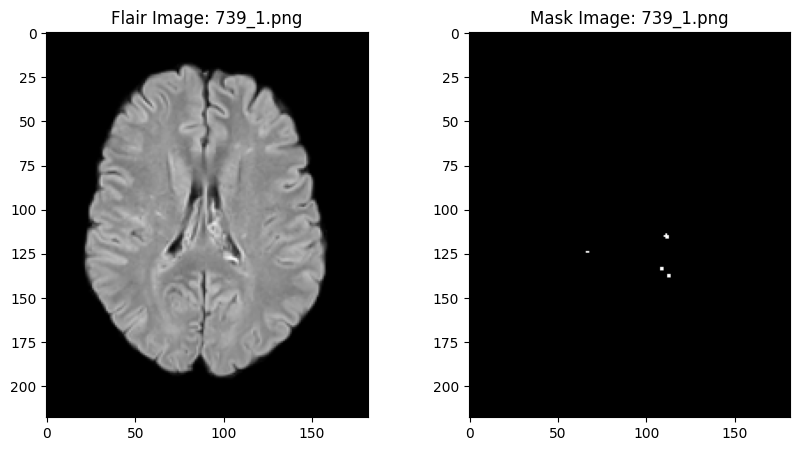

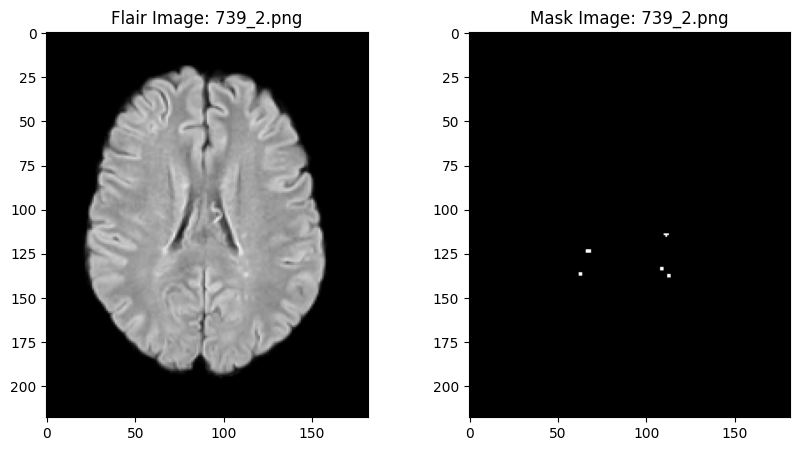

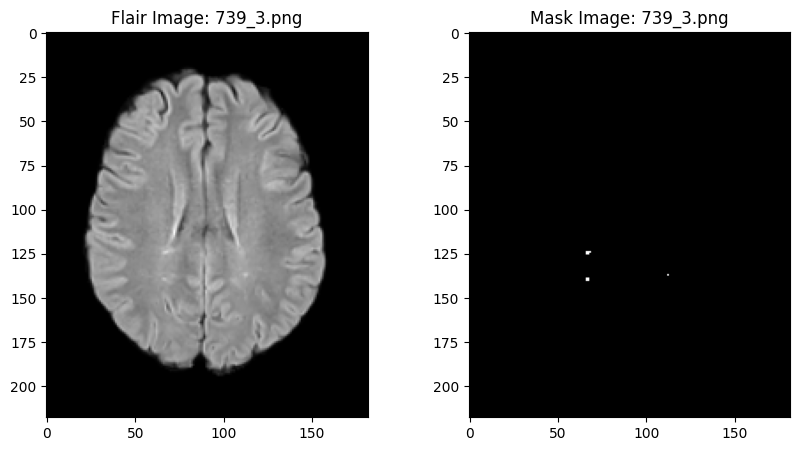

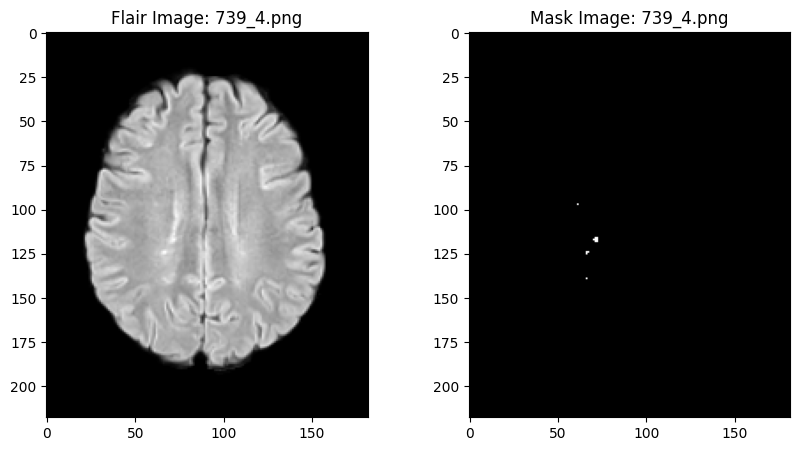

In [2]:
##### Example Usage of the MRIDatasetBuilder
data_folder = "/home/benet/data"
input_folder = "VH"
output_folder = "VH2D"
folders = ["train", "test"]
flair_image = "flair.nii.gz"
mask_image = "lesionMask.nii.gz"
slices_per_example = 5
slices_step = 3
start_slice = 88

dataset_builder = MRIDatasetBuilder(data_folder, input_folder, output_folder, folders, flair_image, mask_image, slices_per_example, slices_step, start_slice)
dataset_builder.build_dataset()
dataset_builder.show_sample()
dataset_builder.show_sample(image_name="739")

# Create a dataset

In [3]:
#### Example Usage of the MRIDataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode
data_dir = "/home/benet/data/VH2D/images/flair"
resolution = 256
batch_size = 32
num_workers = 4

preprocess = Compose(
    [
        Resize(resolution, interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(resolution),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToTensor(),  # Convert to PyTorch tensor
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
        lambda x: x.repeat(3, 1, 1)  # Trick to turn Grayscale into 3 channels
    ]
)

# Create dataset with the defined transformations
dataset = MRIDataset(data_dir, transform=preprocess)
# Create the dataloader
train_dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers= num_workers, shuffle=True
)
print(f"Number of samples in the dataset: {len(dataset)}")
print(f"Number of batches in the dataloader: {len(train_dataloader)}")


Number of samples in the dataset: 285
Number of batches in the dataloader: 9


# Create ans save Latents

In [2]:
from pathlib import Path
import os
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
    print(repo_path)
resolution = 512
processor = LatentImageProcessor(repo_path, output_dir = "/home/benet/data/VH2D/latent_flair_scaled_512", scale=True, 
                                 resolution=resolution, finetuned_vae=False, input_dir = "/home/benet/data/VH2D/images/all/flair")
processor.process_images()

/home/benet/tfg
Device: cuda
Found 570 images in the dataset folder
2280 latent images saved in /home/benet/data/VH2D/latent_flair_scaled_512
